# Mount Drive
We stored preprocessed VCTK here.

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Preparing Data

Extracting already preprocessed VCTK corpus

In [0]:
%%time
!cp '/content/gdrive/My Drive/ML/LibriTTS/VCTK-ttv-32Syn-16Emb-siltrim-23top.tar' .
!tar xf '/content/VCTK-ttv-32Syn-16Emb-siltrim-23top.tar'

CPU times: user 917 ms, sys: 143 ms, total: 1.06 s
Wall time: 3min 18s


# Install Dependencies

In [0]:
!pip install -q tensorflow==2.0.0-beta1 tensorflow-gpu==2.0.0-beta1 pydub webrtcvad

# Download code

In [0]:
!rm -rf SV2MTTS/
!git clone 'https://github.com/sagar-spkt/SV2MTTS.git'
%cd SV2MTTS/
!git checkout VCTK

Cloning into 'SV2MTTS'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 167 (delta 29), reused 32 (delta 14), pack-reused 118
Receiving objects: 100% (167/167), 375.45 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (101/101), done.
/content/SV2MTTS/SV2MTTS
Branch 'VCTK' set up to track remote branch 'VCTK' from 'origin'.
Switched to a new branch 'VCTK'


# Import Required Libraries

fundamental libraries

In [0]:
%cd /content/SV2MTTS

/content/SV2MTTS


In [0]:
import glob
import struct
import shutil
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydub import AudioSegment
import librosa.display as lpd
import hparams

### Disable Tensorflow Eager Execution 

In [0]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.__version__

'2.0.0-beta1'

### Import Models, Generators and Audio Utils

In [0]:
from models import get_full_model, get_speaker_embedding_model, get_synthesizer_model, load_saved_model
from data_loader import SynthesizerTrainGenerator
from utterance_utils import mag_spectro2wav, mel_spectro2wav

# Restore the model at current best checkpoint

In [0]:
checkpoint = 'model184.hdf5'
model = load_saved_model('/content/gdrive/My Drive/ML/voice_clone/training_logs/Rowdy SV2MTTS/SV2MTTS-VCTK-23db-silenced/checkpoints/' + checkpoint)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Extract a batch from the dataset
### Choose train, validation or test set

In [0]:
test_from = 'test'
shuffle = False  # True if random batch is to be choosen

In [0]:
batch = 85
utt = 4
test_gen = SynthesizerTrainGenerator('/content/VCTK-Num-Embbded/' + test_from, shuffle=shuffle, num_buckets=5)
char, spk_embed, mel =  test_gen[batch][0]
utt = len(char) - 1 if utt >= len(char) else utt
len(char)


32

# Predict for the batch choosen
## Same reference utterance as the target utterance

In [0]:
%%time
mel_spectro, mag_spectro, alignments = model.predict([char, spk_embed, mel])

CPU times: user 6.11 s, sys: 1.29 s, total: 7.39 s
Wall time: 9.16 s


## Alignment Plot

Text(0, 0.5, 'characters position')

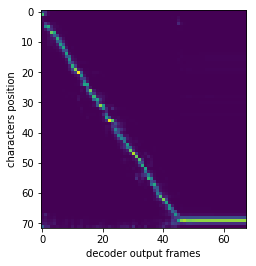

In [0]:
plt.imshow(alignments[utt].T)
plt.xlabel('decoder output frames')
plt.ylabel('characters position')

## Transcript

In [0]:
test_gen.batches[batch]['normalized'][utt]

'The rainbow is a division of white light into many beautiful colors. $'

## Ground truth utterance

In [0]:
y = np.load(test_gen.batches[batch]['utt'][utt])
ipd.Audio(y, rate=32000)

## Predicted utterance

### GL_POWER = **1.5**

In [0]:
y = mag_spectro2wav(mag_spectro[utt], gl_power=1.5)
ipd.Audio(y, rate=32000)

### GL_POWER = **1.3**

In [0]:
y = mag_spectro2wav(mag_spectro[utt], gl_power=1.3)
ipd.Audio(y, rate=32000)

### GL_POWER = **1.0**

In [0]:
# predicted
y = mag_spectro2wav(mag_spectro[utt], gl_power=1)
ipd.Audio(y, rate=32000)

# Randomly shuffle reference utterance

In [0]:
perm = np.random.permutation(len(spk_embed))
spk_embed_perm = spk_embed[perm]

In [0]:
%%time
decoder_pred, postnet_out, alignments = model.predict([char, spk_embed_perm, mel])

CPU times: user 654 ms, sys: 92.7 ms, total: 747 ms
Wall time: 726 ms


Text(0, 0.5, 'characters position')

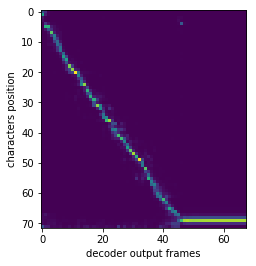

In [0]:
plt.imshow(alignments[utt].T)
plt.xlabel('decoder output frames')
plt.ylabel('characters position')

In [0]:
# transcript
test_gen.batches[batch]['normalized'][perm[utt]][:-1]

'The council has proposed a temporary barrier to protect the monument.'

In [0]:
# reference
y = np.load(test_gen.batches[batch]['utt'][perm[utt]])
ipd.Audio(y, rate=32000)

In [0]:
test_gen.batches[batch]['normalized'][utt]

'The rainbow is a division of white light into many beautiful colors. $'

In [0]:
# predicted
y = mag_spectro2wav(postnet_out[utt], gl_power=1.5)
ipd.Audio(y, rate=32000)

In [0]:
# predicted
y = mag_spectro2wav(postnet_out[utt], gl_power=1.3)
ipd.Audio(y, rate=32000)

In [0]:
# predicted
y = mag_spectro2wav(postnet_out[utt], gl_power=1.0)
ipd.Audio(y, rate=32000)